In [ ]:
King - man +woman = Queen
Embedding -> Word / sentence -> Meaningful

Query ("Tell me about Rags Brain") -> Knowledge_Pdf(".....") -> relevant info  -> LLM (Query + Relevant info)-> ANS

QUery -> Multiple Pdf (10)-> Information pull -> LLM -> ANS

Query -> Tell me about Rags Brain -> V1

Knowledge pdf (text)->pages-> v2,v3,v4,v5, .....,v100           (V1,closest)->V3   -> LLM (Query _+ info relevant)-> ANS



# 📘 Word Embeddings in NLP
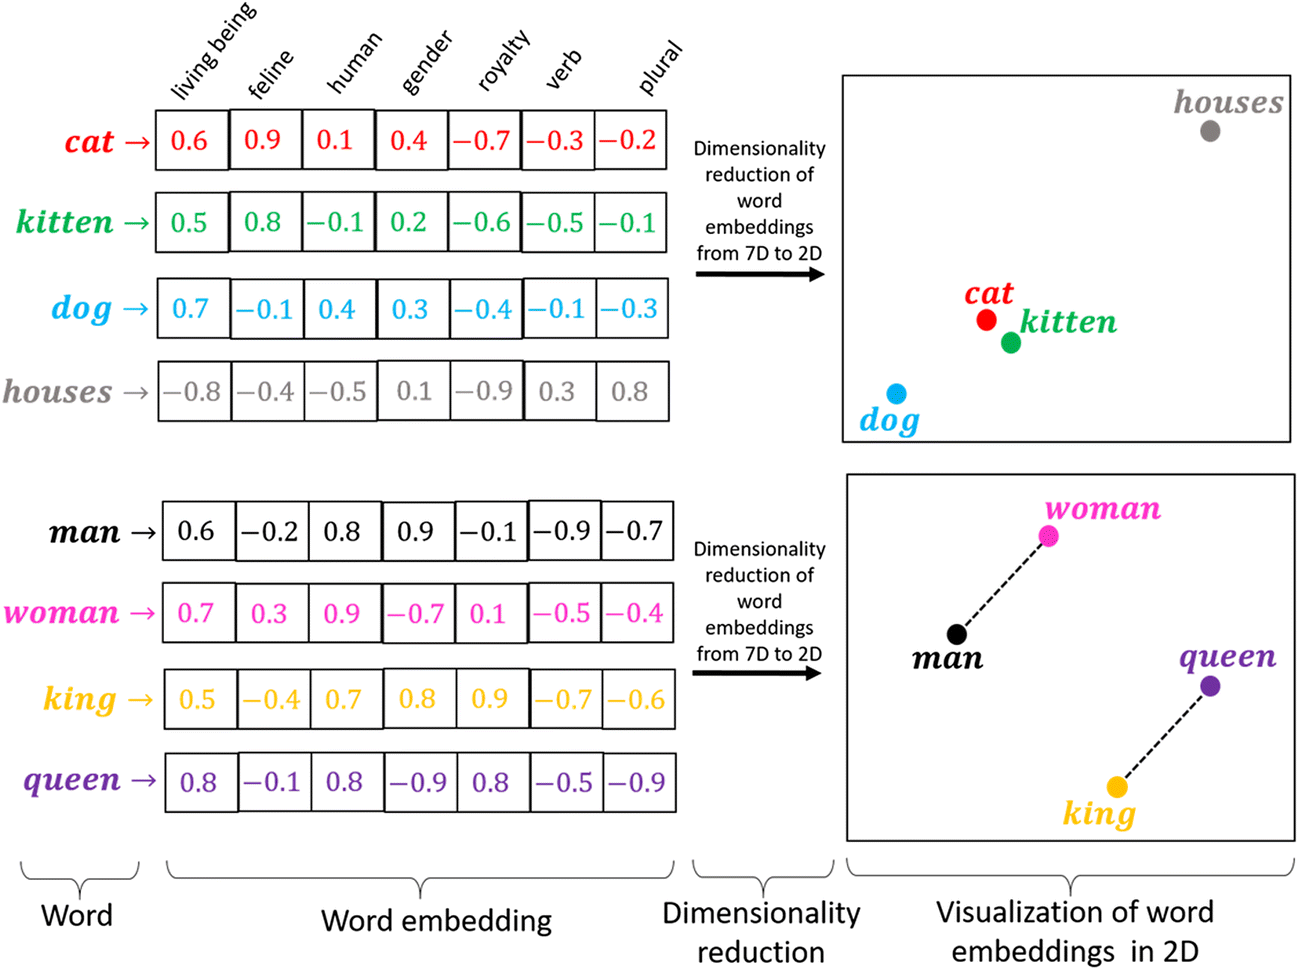
---



In this notebook, we will explore different techniques for representing text as vectors (embeddings).

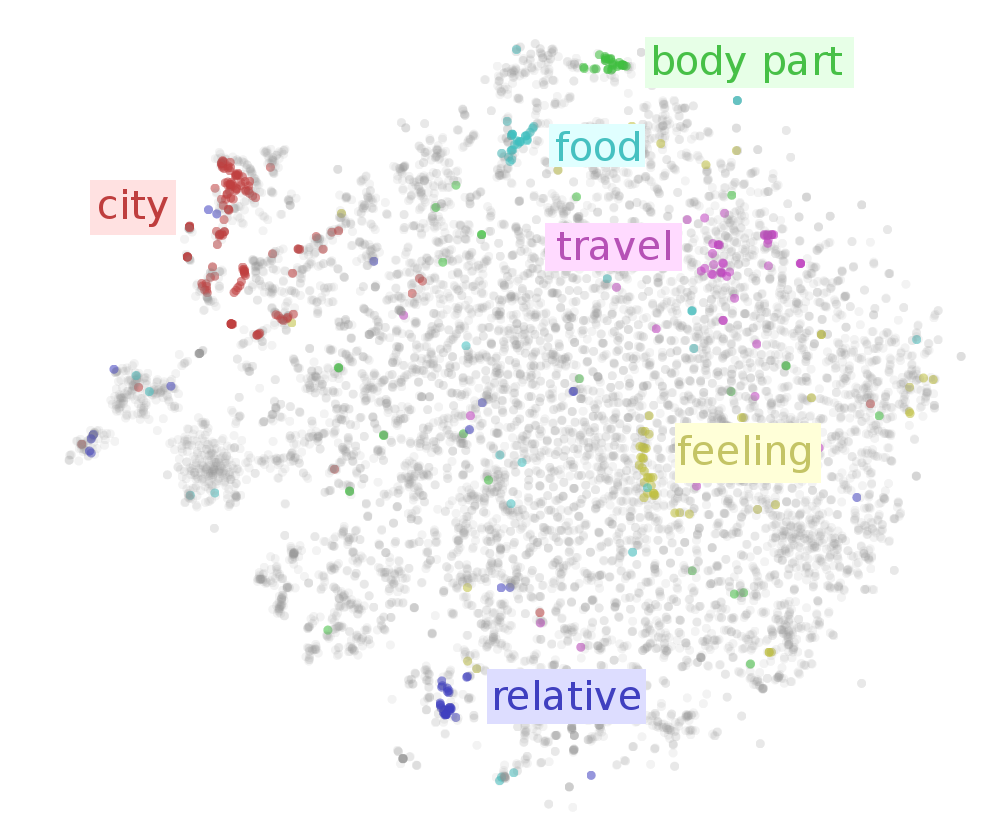

## Topics Covered
- What are word embeddings?
- TF-IDF: Term Frequency – Inverse Document Frequency
- Word2Vec: CBOW and Skip-gram models
- GloVe embeddings
- Pre-trained embeddings vs. custom-trained
- Training a simple sentiment analysis model on IMDB reviews using embeddings

We will train a simple sentiment classifier on the IMDB dataset using **BERT embeddings**.
Later, you can replace embeddings with **TF-IDF, Word2Vec, or GloVe** to compare performance.

In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
import torch
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 🔹 Load IMDB dataset

In [ ]:
dataset = load_dataset('imdb')
train_df = dataset['train'].to_pandas().sample(2000, random_state=42)
test_df = dataset['test'].to_pandas().sample(1000, random_state=42)
train_df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

,text,label
6868,"Dumb is as dumb does, in this thoroughly unint...",0
24016,I dug out from my garage some old musicals and...,1
9668,After watching this movie I was honestly disap...,0
13640,This movie was nominated for best picture but ...,1
14018,Just like Al Gore shook us up with his painful...,1


## 🔹 TF-IDF Theory
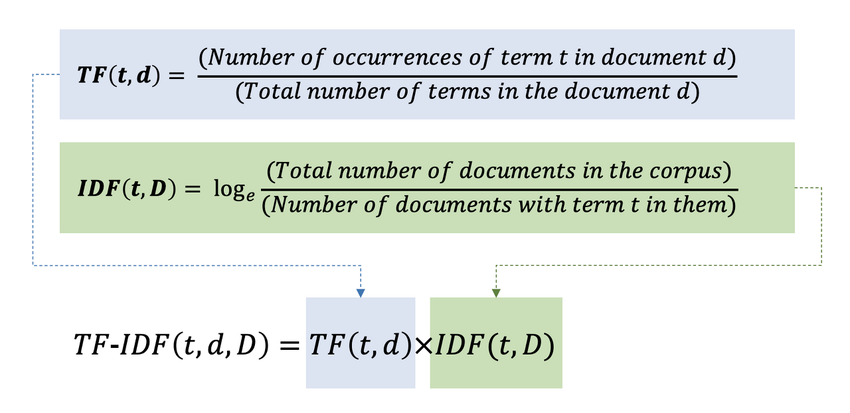

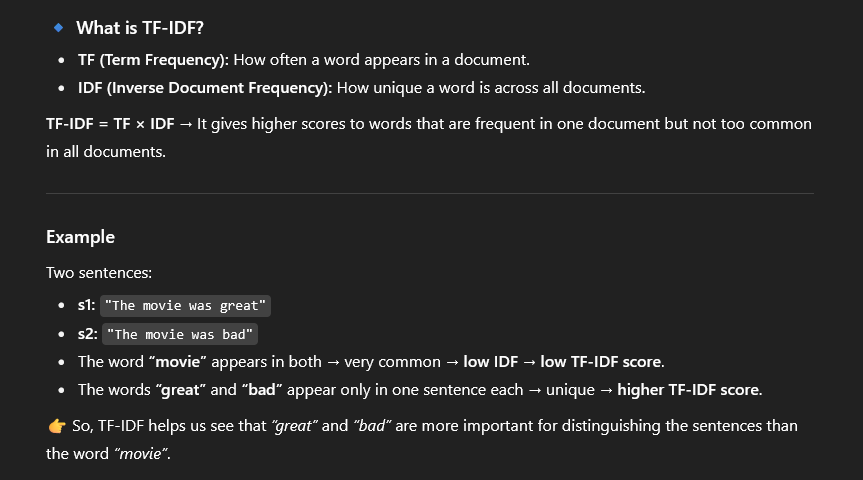

TF-IDF stands for **Term Frequency – Inverse Document Frequency**.
- Term Frequency: How often a word appears in a document.
- Inverse Document Frequency: How unique the word is across all documents.

TF-IDF assigns higher weight to words that are frequent in a document but rare across documents.

In [ ]:
TF(Bad)=1/4 IDF(Bad)=loge(2/1) >0
Tf(Movie)= IDF (Movie)loge (2/2)=0

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_df['text'])
X_test_tfidf = vectorizer.transform(test_df['text'])

clf = LogisticRegression(max_iter=200)
clf.fit(X_train_tfidf, train_df['label'])
preds = clf.predict(X_test_tfidf)
print('TF-IDF Accuracy:', accuracy_score(test_df['label'], preds))

TF-IDF Accuracy: 0.822


## 🔹 Word2Vec Theory
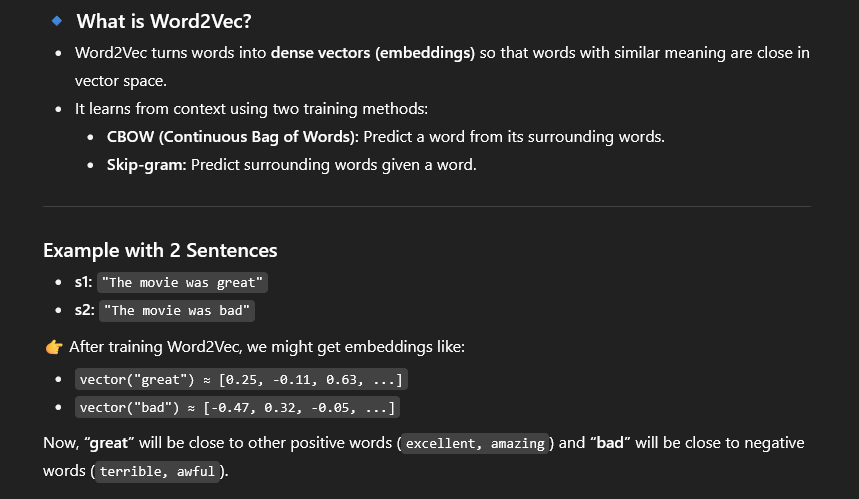
Word2Vec is a neural network model that learns word embeddings.
- **CBOW (Continuous Bag of Words):** Predicts a target word from context words.
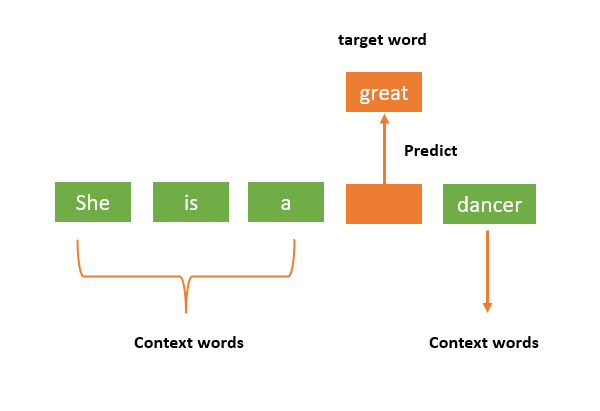
- **Skip-gram:** Predicts context words from a target word.
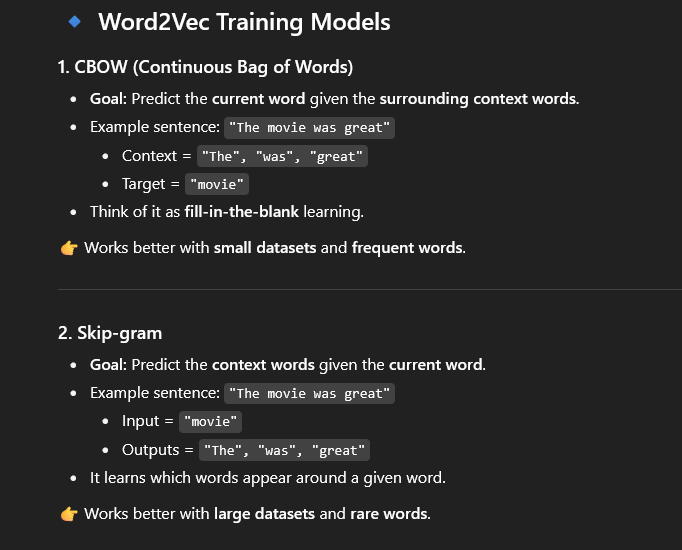

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab') # Add this line

sentences = [word_tokenize(text.lower()) for text in train_df['text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, sg=1)
print(w2v_model.wv.most_similar('movie'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


[('film', 0.900288999080658), ('flick', 0.8397611379623413), ('documentary', 0.8377119898796082), ('junk', 0.8183355331420898), ('mess', 0.8110421299934387), ('utterly', 0.8033279776573181), ('picture', 0.8029654026031494), ('sequel', 0.8015543818473816), ('comment', 0.8013471961021423), ('review', 0.7998998761177063)]


## 🔹 GloVe Theory
GloVe (Global Vectors for Word Representation) uses **global co-occurrence statistics** of words in a corpus.
- Unlike Word2Vec, which is predictive, GloVe is a count-based model.
- It captures semantic relationships like *king - man + woman ≈ queen*.

In [ ]:
import gensim.downloader as api

glove_model = api.load('glove-wiki-gigaword-50')
print(glove_model.most_similar('movie'))

[==================================================] 100.0% 66.0/66.0MB downloaded
[('movies', 0.9322481155395508), ('film', 0.9310100078582764), ('films', 0.8937394618988037), ('comedy', 0.8902585506439209), ('hollywood', 0.8718216419219971), ('drama', 0.8341657519340515), ('sequel', 0.8222616314888), ('animated', 0.8216581344604492), ('remake', 0.812495768070221), ('show', 0.8105834126472473)]


## 🔹 BERT Embeddings for IMDB Sentiment
We now use DistilBERT to generate embeddings and train a classifier.

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**{k: v for k, v in inputs.items() if k != 'token_type_ids'})
    return outputs.last_hidden_state[:,0,:].numpy()

X_train = [get_embedding(t) for t in train_df['text'][:500]]
y_train = train_df['label'][:500]
X_test = [get_embedding(t) for t in test_df['text'][:200]]
y_test = test_df['label'][:200]

import numpy as np
X_train = np.array(X_train).squeeze(1)
X_test = np.array(X_test).squeeze(1)

clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print('BERT Embedding Accuracy:', accuracy_score(y_test, preds))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

BERT Embedding Accuracy: 0.76
